In [1]:
from IPython.display import Image

# Lab 2 - Logistic Regression (LR) with MNIST

This lab corresponds to Module 2 of the "Deep Learning Explained" course. We assume that you have successfully completed Lab 1 (Downloading the MNIST data).

In this lab we will build and train a Multiclass Logistic Regression model using the MNIST data. 

## Introduction

**Problem**:
Optical Character Recognition (OCR) is a hot research area and there is a great demand for automation. The MNIST data is comprised of hand-written digits with little background noise making it a nice dataset to create, experiment and learn deep learning models with reasonably small comptuing resources.

In [2]:
# Figure 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

**Goal**:
Our goal is to train a classifier that will identify the digits in the MNIST dataset. 

**Approach**:
There are 4 stages in this lab: 
- **Data reading**: We will use the CNTK Text reader.  
- **Data preprocessing**: Covered in part A (suggested extension section). 
- **Model creation**: Multiclass Logistic Regression model.
- **Train-Test-Predict**: This is the same workflow introduced in the lectures

## Logistic Regression
[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) (LR) is a fundamental machine learning technique that uses a linear weighted combination of features and generates probability-based predictions of different classes.  

There are two basic forms of LR: **Binary LR** (with a single output that can predict two classes) and **multiclass LR** (with multiple outputs, each of which is used to predict a single class).  

![LR-forms](http://www.cntk.ai/jup/cntk103b_TwoFormsOfLR-v3.png)

In **Binary Logistic Regression** (see top of figure above), the input features are each scaled by an associated weight and summed together.  The sum is passed through a squashing (aka activation) function and generates an output in [0,1].  This output value is then compared with a threshold (such as 0.5) to produce a binary label (0 or 1), predicting 1 of 2 classes.  This technique supports only classification problems with two output classes, hence the name binary LR.  In the binary LR example shown above, the [sigmoid][] function is used as the squashing function.

[sigmoid]: https://en.wikipedia.org/wiki/Sigmoid_function

In **Multiclass Linear Regression** (see bottom of figure above), 2 or more output nodes are used, one for each output class to be predicted.  Each summation node uses its own set of weights to scale the input features and sum them together. Instead of passing the summed output of the weighted input features through a sigmoid squashing function, the output is often passed through a [softmax][] function (which in addition to squashing, like the sigmoid, the softmax normalizes each nodes' output value using the sum of all unnormalized nodes). (Details in the context of MNIST image to follow)

We will use multiclass LR for classifying the MNIST digits (0-9) using 10 output nodes (1 for each of our output classes).  In our approach, we will move the softmax function out of the model and into our Loss function used in training (details to follow).

[softmax]: https://en.wikipedia.org/wiki/Softmax_function

In [3]:
# Import the relevant components
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C

%matplotlib inline

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [4]:
# Select the right target device when this notebook is being tested:
# if 'TEST_DEVICE' in os.environ:
#     if os.environ['TEST_DEVICE'] == 'cpu':
#         C.device.try_set_default_device(C.device.cpu())
#     else:
#         C.device.try_set_default_device(C.device.gpu(0))

In [5]:
# Test for CNTK version
# if not C.__version__ == "2.0":
#     raise Exception("this lab is designed to work with 2.0. Current Version: " + C.__version__) 

## Initialization

In [6]:
# Ensure we always get the same amount of randomness
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

# Define the data dimensions
input_dim = 784
num_output_classes = 10

## Data reading

There are different ways one can read data into CNTK. The easiest way is to load the data in memory using NumPy / SciPy / Pandas readers. However, this can be done only for small data sets. Since deep learning requires large amount of data we have chosen in this course to show how to leverage built-in distributed readers that can scale to terrabytes of data with little extra effort. 

We are using the MNIST data you have downloaded using Lab 1 DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels. Thus the number of features is equal to 784 (= 28 x 28 pixels), 1 per pixel. The variable `num_output_classes` is set to 10 corresponding to the number of digits (0-9) in the dataset.

In Lab 1, the data was downloaded and written to 2 CTF (CNTK Text Format) files, 1 for training, and 1 for testing. Each line of these text files takes the form:

    |labels 0 0 0 1 0 0 0 0 0 0 |features 0 0 0 0 ... 
                                                  (784 integers each representing a pixel)
    
We are going to use the image pixels corresponding the integer stream named "features". We define a `create_reader` function to read the training and test data using the [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html?highlight=ctfdeserializer#cntk.io.CTFDeserializer). The labels are [1-hot encoded](https://en.wikipedia.org/wiki/One-hot). Refer to Lab 1 for data format visualizations. 

In [7]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    labelStream = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    
    deserailizer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels = labelStream, features = featureStream))
            
    return C.io.MinibatchSource(deserailizer,
       randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [8]:
# Ensure the training and test data is generated and available for this lab.
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False

for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing Lab1_MNIST_DataLoader")
    
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


# Model Creation

A multiclass logistic regression (LR) network is a simple building block that has been effectively powering many ML 
applications in the past decade. The figure below summarizes the model in the context of the MNIST data.

![mnist-LR](https://www.cntk.ai/jup/cntk103b_MNIST_LR.png)

LR is a simple linear model that takes as input, a vector of numbers describing the properties of what we are classifying (also known as a feature vector, $\bf \vec{x}$, the pixels in the input MNIST digit image) and emits the *evidence* ($z$). For each of the 10 digits, there is a vector of weights corresponding to the input pixels as show in the figure. These 10 weight vectors define the weight matrix ($\bf {W}$) with dimension of 10 x 784.  Each feature in the input layer is connected with a summation node by a corresponding weight $w$ (individual weight values from the $\bf{W}$ matrix). Note there are 10 such nodes, 1 corresponding to each digit to be classified. 

The first step is to compute the evidence for an observation. 

$$\vec{z} = \textbf{W} \bf \vec{x}^T + \vec{b}$$ 

where $\bf{W}$ is the weight matrix of dimension 10 x 784 and $\vec{b}$ is known as the *bias* vector with lenght 10, one for each digit. 

The evidence ($\vec{z}$) is not squashed (hence no activation). Instead the output is normalized using a [softmax](https://en.wikipedia.org/wiki/Softmax_function) function such that all the outputs add up to a value of 1, thus lending a probabilistic iterpretation to the prediction. In CNTK, we use the softmax operation combined with the cross entropy error as our Loss Function for training.

Network input and output: 
- **input** variable (a key CNTK concept): 
>An **input** variable is a container in which we fill different observations, in this case image pixels, during model learning (a.k.a.training) and model evaluation (a.k.a. testing). Thus, the shape of the `input` must match the shape of the data that will be provided.  For example, when data are images each of  height 10 pixels  and width 5 pixels, the input feature dimension will be 50 (representing the total number of image pixels).


**Knowledge Check:** What is the input dimension of your chosen model? This is fundamental to our understanding of variables in a network or model representation in CNTK.

In [9]:
input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

## Logistic Regression network setup

The CNTK Layers module provides a Dense function that creates a fully connected layer which performs the above operations of weighted input summing and bias addition.  

In [10]:
#C.splice?

In [11]:
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform()):
        #r = C.layers.Dense(num_output_classes, activation = None)(features) # 7.41%
        #r = C.layers.Dense(num_output_classes, activation = None)( C.square(features) ) # 7.71% 
        #r = C.layers.Dense(num_output_classes, activation = None)(C.sqrt(features)) # 7.27%
        # splice()
        r = C.layers.Dense(num_output_classes, activation = None)( C.splice(features, 
                                                                            C.square(features),
                                                                            C.sqrt(features)
                                                                             , axis=0)  )  # 6.70%
        return r

`z` will be used to represent the output of a network.

In [12]:
# Scale the input to 0-1 range by dividing each pixel by 255.
input_s = input/255
z = create_model(input_s)

## Training

Below, we define the **Loss** function, which is used to guide weight changes during training.  

As explained in the lectures, we use the `softmax` function to map the accumulated evidences or activations to a probability distribution over the classes (Details of the [softmax function][] and other [activation][] functions).

[softmax function]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[activation]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

We minimize the cross-entropy between the label and predicted probability by the network.

In [13]:
loss = C.cross_entropy_with_softmax(z, label)

#### Evaluation

Below, we define the **Evaluation** (or metric) function that is used to report a measurement of how well our model is performing.

For this problem, we choose the **classification_error()** function as our metric, which returns the average error over the associated samples (treating a match as "1", where the model's prediction matches the "ground truth" label, and a non-match as "0").

In [14]:
label_error = C.classification_error(z, label)

### Configure training

The trainer strives to reduce the `loss` function by different optimization approaches, [Stochastic Gradient Descent][] (`sgd`) being one of the most popular. Typically, one would start with random initialization of the model parameters. The `sgd` optimizer would calculate the `loss` or error between the predicted label against the corresponding ground-truth label and using [gradient-decent][] generate a new set model parameters in a single iteration. 

The aforementioned model parameter update using a single observation at a time is attractive since it does not require the entire data set (all observation) to be loaded in memory and also requires gradient computation over fewer datapoints, thus allowing for training on large data sets. However, the updates generated using a single observation sample at a time can vary wildly between iterations. An intermediate ground is to load a small set of observations and use an average of the `loss` or error from that set to update the model parameters. This subset is called a *minibatch*.

With minibatches, we sample observations from the larger training dataset. We repeat the process of model parameters update using different combination of training samples and over a period of time minimize the `loss` (and the error metric). When the incremental error rates are no longer changing significantly or after a preset number of maximum minibatches to train, we claim that our model is trained.

One of the key optimization parameters is called the `learning_rate`. For now, we can think of it as a scaling factor that modulates how much we change the parameters in any iteration.
With this information, we are ready to create our trainer. 

[optimization]: https://en.wikipedia.org/wiki/Category:Convex_optimization
[Stochastic Gradient Descent]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[gradient-decent]: http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html

In [15]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.2
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

First let us create some helper functions that will be needed to visualize different functions associated with training.

In [16]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

<a id='#Run the trainer'></a>
### Run the trainer

We are now ready to train our fully connected neural net. We want to decide what data we need to feed into the training engine.

In this example, each iteration of the optimizer will work on `minibatch_size` sized samples. We would like to train on all 60000 observations. Additionally we will make multiple passes through the data specified by the variable `num_sweeps_to_train_with`. With these parameters we can proceed with training our simple feed forward network.

In [17]:
# Initialize the parameters for the trainer
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [18]:
# Create the reader to training data set
reader_train = create_reader(train_file, True, input_dim, num_output_classes)

# Map the data streams to the input and labels.
input_map = {
    label  : reader_train.streams.labels,
    input  : reader_train.streams.features
} 

# Run the trainer on and perform model training
training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    
    # Read a mini batch from the training data file
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 2.3334, Error: 87.50%
Minibatch: 500, Loss: 0.4914, Error: 12.50%
Minibatch: 1000, Loss: 0.2090, Error: 1.56%
Minibatch: 1500, Loss: 0.3986, Error: 15.62%
Minibatch: 2000, Loss: 0.1461, Error: 3.12%
Minibatch: 2500, Loss: 0.1411, Error: 4.69%
Minibatch: 3000, Loss: 0.0817, Error: 1.56%
Minibatch: 3500, Loss: 0.3246, Error: 10.94%
Minibatch: 4000, Loss: 0.4256, Error: 10.94%
Minibatch: 4500, Loss: 0.2398, Error: 4.69%
Minibatch: 5000, Loss: 0.1558, Error: 3.12%
Minibatch: 5500, Loss: 0.1034, Error: 3.12%
Minibatch: 6000, Loss: 0.1260, Error: 3.12%
Minibatch: 6500, Loss: 0.2821, Error: 10.94%
Minibatch: 7000, Loss: 0.1269, Error: 3.12%
Minibatch: 7500, Loss: 0.2953, Error: 7.81%
Minibatch: 8000, Loss: 0.0966, Error: 3.12%
Minibatch: 8500, Loss: 0.1188, Error: 3.12%
Minibatch: 9000, Loss: 0.0875, Error: 3.12%


Let us plot the errors over the different training minibatches. Note that as we progress in our training, the loss decreases though we do see some intermediate bumps.  

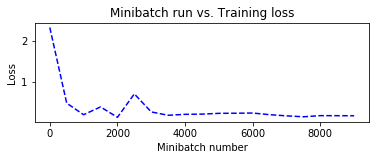

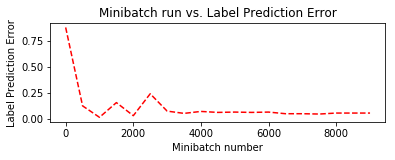

In [19]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## Evaluation / Testing 

Now that we have trained the network, let us evaluate the trained network on the test data. This is done using `trainer.test_minibatch`.

In [20]:
# Read the training data
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

# Test data for trained model
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    
    # We are loading test data in batches specified by test_minibatch_size
    # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
    # with one pixel per dimension that we will encode / decode with the 
    # trained model.
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

# Average of evaluation errors of all test minibatches
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Average test error: 6.70%


We have so far been dealing with aggregate measures of error. Let us now get the probabilities associated with individual data points. For each observation, the `eval` function returns the probability distribution across all the classes. The classifier is trained to recognize digits, hence has 10 classes. First let us route the network output through a `softmax` function. This maps the aggregated activations across the network to probabilities across the 10 classes.

In [21]:
out = C.softmax(z)

Let us test a small minibatch sample from the test data.

In [22]:
# Read the data for evaluation
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {input: reader_eval.streams.features} 

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].asarray()
img_data = data[input].asarray()
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [23]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [24]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [4, 5, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2, 2]
Predicted: [4, 6, 6, 7, 5, 9, 7, 4, 6, 1, 6, 0, 4, 9, 3, 7, 1, 2, 7, 5, 8, 6, 3, 2, 2]


As you can see above, our model is not yet perfect.  

Let us visualize one of the test images and its associated label.  Do they match?

Image Label:  9


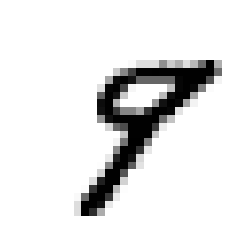

In [25]:
# Plot a random image
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

**Suggested Explorations**

A. Change the `minibatch_size` parameter (from 64) to 128 and then to 512 during training. What is the observed average test error rate (rounded to 2nd decimal place) with each new model?

B. Increase the number of sweeps.  How does the test error change?

C. Can you change the network to reduce the training error rate? When do you see *overfitting* happening?  

D. Lets now add more features to our model. We will add square of the input values as additional features. You will take the input pixels, scale them by 255. Use `C.square` and `C.splice` functions to create a new model. Use this model to perform classification. Note: use the original setting for the rest of the notebook

E. Now add sqrt as another set of features to the model. Use this model to perform classification.